## Prediction of Daily PM10 and PM2.5

### Importing Data

The particulate matter data show some differences each other, on one hand the PM2.5 present fewer input variables as well some different type of variables if we compare these data with PM10.

In [1]:
#Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.io import loadmat

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import max_error, median_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


from statsmodels.tsa.seasonal import seasonal_decompose

import pylab
import scipy.stats as stats

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def read_files_PM():
    #Reading data and naming Columns
    PM25data=pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")
    PM10data=loadmat('data_Polish.mat')
    PM10data=pd.DataFrame.from_dict(PM10data['x'])
    PM10data.columns = ['PM_10','SO2','NO_2','OZON','WIND_SPEED', 'WIND_DIR', 'TEMP', 'PROM_SLON', 'WILGOT', 'WIND_X', 'WIND_Y']
    return PM25data, PM10data 

### NAN Values in datasets 

There are some NaN numbers in the PM2.5 data, it can be seen in the following two cells. On possible way may be to interpolate the missing values with the known ones and ensure all dataset will have defined values.The interpolation is then carried out, nevertheless, the first 24 data points are still missing, thus they are removed completely.

In [3]:
#Interpolation and removing NAN Values from PM2.5 data, new data index is set. 
PM25data, PM10data =read_files_PM()
PM25_interpolate=PM25data['pm2.5'].fillna(method='ffill')
PM25data_clean=PM25data
PM25data_clean['pm2.5']=PM25_interpolate
PM25data_clean=PM25data_clean[24:]
i_PM10 = pd.date_range('2006-01-01', periods=len(PM10data), freq='H')
PM10data.index=i_PM10
PM25data_clean=PM25data_clean.set_index(['year', 'month','day','hour'])
PM25data=PM25data_clean
PM25data.drop(['No'], axis=1, inplace=True)
PM25data['new_idx']=pd.to_datetime(PM25data.index.to_frame())
PM25data.set_index('new_idx', inplace=True)

In [4]:
#result = seasonal_decompose(PM10data['TEMP'])
#fig = result.plot()

### Creating Daily Regressors

The daily regressors are now generated calculating the mean of each variable every 24 hours, the vales from non numeric variables are removed from the newly created dataframe. The boxplots show higher variability in the PM2.5 data, in both data however, several outliers points appear. Then, the datasets are scaled in order to have be processed by the models. 

In [5]:
#Minimum and maximum->
Max_PM25=PM10data.resample('d').max()
Min_PM25=PM10data.resample('d').min()

#Means-> 
PM25_daily=PM25data.resample('d').mean()
PM10_daily=PM10data.resample('d').mean()

In [6]:
X_PM10=PM10_daily[['SO2', 'NO_2', 'OZON', 'WIND_SPEED', 'WIND_DIR', 'TEMP','PROM_SLON', 'WILGOT', 'WIND_X', 'WIND_Y']]
y_PM10=PM10_daily[['PM_10']]

In [7]:
X_PM25=PM25_daily[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is']] #cbwd,Ir discarded 
y_PM25=PM25_daily[['pm2.5']]

In [8]:
#Discarding first day of PM and last day of Meteorological var
y_PM25=y_PM25.drop(y_PM25.head(1).index)
X_PM25=X_PM25.drop(X_PM25.tail(1).index)
y_PM10=y_PM10.drop(y_PM10.head(1).index)
X_PM10=X_PM10.drop(X_PM10.tail(1).index)

In [9]:
#Standardization of data
def scaling_PMs(X_PM10, y_PM10, X_PM25, y_PM25):  
    scaler_X_PM10 = preprocessing.StandardScaler().fit(X_PM10.values)
    scaler_X_PM25 = preprocessing.StandardScaler().fit(X_PM25.values)
    scaler_y_PM10 = preprocessing.StandardScaler().fit(y_PM10.values.reshape(-1, 1) )
    scaler_y_PM25 = preprocessing.StandardScaler().fit(y_PM25.values.reshape(-1, 1) )
    #Other type of normalization=>
    #MinMaxScaler #minmax_scale #MaxAbsScaler #StandardScaler #RobustScaler 
    #Normalizer #QuantileTransformer #PowerTransformer
    X_PM10_scaled=scaler_X_PM10.transform(X_PM10)
    X_PM25_scaled=scaler_X_PM25.transform(X_PM25)
    y_PM10_scaled=scaler_y_PM10.transform(y_PM10.values.reshape(-1,1))
    y_PM25_scaled=scaler_y_PM25.transform(y_PM25.values.reshape(-1,1))
    return X_PM10_scaled,y_PM10_scaled, X_PM25_scaled, y_PM25_scaled, scaler_X_PM10, scaler_y_PM10, scaler_X_PM25, scaler_y_PM25

In [10]:
X_PM10_scaled,y_PM10_scaled, X_PM25_scaled, y_PM25_scaled, scaler_X_PM10, scaler_y_PM10, scaler_X_PM25, scaler_y_PM25=scaling_PMs(X_PM10, y_PM10, X_PM25, y_PM25)

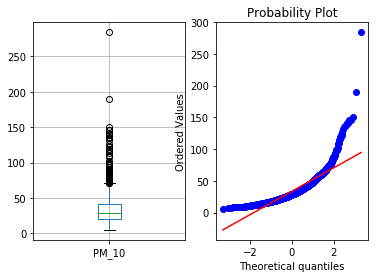

In [11]:
#Boxplots of Daily PMs
PM10_daily=PM10data.resample('d').mean()
PM25_daily=PM25data.resample('d').mean()

fig, axs = plt.subplots(1,2)
boxplot1 = PM10_daily.boxplot(column=['PM_10'], ax=axs[0])
stats.probplot(y_PM10['PM_10'], dist="norm", plot=axs[1])
pylab.show()

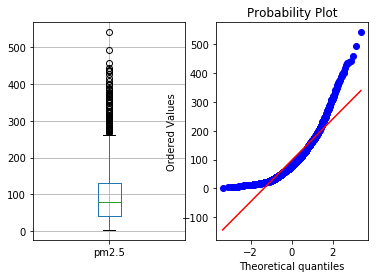

In [12]:
fig, axs = plt.subplots(1,2)
PM25_daily.boxplot(column=['pm2.5'], ax=axs[0])
stats.probplot(y_PM25['pm2.5'], dist="norm", plot=axs[1])
pylab.show()

### Splitting data into Training and Testing samples - Cross-Validation

The data is split leaving some part out of the process, this part will be used to evualuate the performance of predictions. It is usually selected arround 70% or 80% of samples for learning the model.

In [13]:
#Percentage of Testing Data, Remainder is training data
splitter_PM10=0.10 
splitter_PM25=0.10

In [14]:
#Splitting training and testing
X_train_PM10, X_test_PM10, y_train_PM10, y_test_PM10 = train_test_split(X_PM10_scaled, y_PM10_scaled, test_size=splitter_PM10, shuffle='True')
X_train_PM25, X_test_PM25, y_train_PM25, y_test_PM25 = train_test_split(X_PM25_scaled, y_PM25_scaled, test_size=splitter_PM25, shuffle='True')

In [15]:
#PM10 MLP
mlp_nn = MLPRegressor(hidden_layer_sizes=(32,16,16), activation='tanh', solver='lbfgs')
mlp_nn.fit(X_train_PM10, y_train_PM10.reshape(len(y_train_PM10),))

y_predict_train_PM10=mlp_nn.predict(X_train_PM10)
y_predict_test_PM10=mlp_nn.predict(X_test_PM10)

#Descalating outputs
y_predict_train_PM10_descaled=scaler_y_PM10.inverse_transform(y_predict_train_PM10)
y_train_PM10_descaled=scaler_y_PM10.inverse_transform(y_train_PM10)

y_predict_test_PM10_descaled=scaler_y_PM10.inverse_transform(y_predict_test_PM10)
y_test_PM10_descaled=scaler_y_PM10.inverse_transform(y_test_PM10)

In [16]:
#PM25 MLP
mlp_nn_PM25 = MLPRegressor(hidden_layer_sizes=(32,16,16), activation='tanh', solver='lbfgs')
mlp_nn_PM25.fit(X_train_PM25, y_train_PM25.reshape(len(y_train_PM25),))

y_predict_train_PM25=mlp_nn_PM25.predict(X_train_PM25)
y_predict_test_PM25=mlp_nn_PM25.predict(X_test_PM25)

#Descalating outputs
y_predict_train_PM25_descaled=scaler_y_PM25.inverse_transform(y_predict_train_PM25)
y_train_PM25_descaled=scaler_y_PM25.inverse_transform(y_train_PM25)
y_predict_test_PM25_descaled=scaler_y_PM25.inverse_transform(y_predict_test_PM25)
y_test_PM25_descaled=scaler_y_PM25.inverse_transform(y_test_PM25)

In [17]:
def Wrap_Performance():
    lst=np.array(["Model","Layers","Optimization","MAE_Train(ug/m3)","MAE_Test(ug/m3)", "MAPE_Train(%)","MAPE_Test(%)"])
    Performance_PM10=pd.DataFrame(columns=lst)
    Performance_PM10["Model"]=["MLP_Regressor"]
    Performance_PM10["Layers"]=str(mlp_nn.hidden_layer_sizes)
    Performance_PM10["Optimization"]=["None"]  
    Performance_PM10["MAE_Train(ug/m3)"]=median_absolute_error(y_predict_train_PM10_descaled,y_train_PM10_descaled)
    Performance_PM10["MAE_Test(ug/m3)"]=median_absolute_error(y_predict_test_PM10_descaled,y_test_PM10_descaled)
    Performance_PM10["MAPE_Train(%)"]=mean_absolute_percentage_error(y_predict_train_PM10_descaled,y_train_PM10_descaled)
    Performance_PM10["MAPE_Test(%)"]=mean_absolute_percentage_error(y_predict_test_PM10_descaled,y_test_PM10_descaled)
    return Performance_PM10

def Wrap_Performance_PM25():
    lst=np.array(["Model","Layers","Optimization","MAE_Train(ug/m3)","MAE_Test(ug/m3)", "MAPE_Train(%)","MAPE_Test(%)"])
    Performance_PM25=pd.DataFrame(columns=lst)
    Performance_PM25["Model"]=["MLP_Regressor"]
    Performance_PM25["Layers"]=str(mlp_nn_PM25.hidden_layer_sizes)
    Performance_PM25["Optimization"]=["None"]
    Performance_PM25["MAE_Train(ug/m3)"]=median_absolute_error(y_predict_train_PM25_descaled,y_train_PM25_descaled)
    Performance_PM25["MAE_Test(ug/m3)"]=median_absolute_error(y_predict_test_PM25_descaled,y_test_PM25_descaled)
    Performance_PM25["MAPE_Train(%)"]=mean_absolute_percentage_error(y_predict_train_PM25_descaled,y_train_PM25_descaled)
    Performance_PM25["MAPE_Test(%)"]=mean_absolute_percentage_error(y_predict_test_PM25_descaled,y_test_PM25_descaled)
    return Performance_PM25

In [18]:
Performance_PM10=Wrap_Performance()
Performance_PM10

,Model,Layers,Optimization,MAE_Train(ug/m3),MAE_Test(ug/m3),MAPE_Train(%),MAPE_Test(%)
0,MLP_Regressor,"(32, 16, 16)",None,4.258265,10.436585,63.783969,71.497941


In [19]:
Performance_PM25=Wrap_Performance_PM25()
Performance_PM25

,Model,Layers,Optimization,MAE_Train(ug/m3),MAE_Test(ug/m3),MAPE_Train(%),MAPE_Test(%)
0,MLP_Regressor,"(32, 16, 16)",None,31.404695,38.815501,102.609799,89.849986
